# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [31]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5.3e-9, 5.1e-9, 5.03e-9]
regularization_strengths = [3e6, 4e6, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for rl in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rl, reg=reg,
                      num_iters=20000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        acc = np.mean(y_val == y_val_pred)
        if acc > best_val:
            best_val = acc
            best_svm = svm
        results[(rl, reg)] = (train_acc, acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 20000: loss 4844.994215
iteration 100 / 20000: loss 16.542731
iteration 200 / 20000: loss 9.011741
iteration 300 / 20000: loss 9.000014
iteration 400 / 20000: loss 8.999995
iteration 500 / 20000: loss 8.999995
iteration 600 / 20000: loss 8.999995
iteration 700 / 20000: loss 8.999994
iteration 800 / 20000: loss 8.999997
iteration 900 / 20000: loss 8.999995
iteration 1000 / 20000: loss 8.999994
iteration 1100 / 20000: loss 8.999993
iteration 1200 / 20000: loss 8.999993
iteration 1300 / 20000: loss 8.999995
iteration 1400 / 20000: loss 8.999993
iteration 1500 / 20000: loss 8.999994
iteration 1600 / 20000: loss 8.999994
iteration 1700 / 20000: loss 8.999995
iteration 1800 / 20000: loss 8.999994
iteration 1900 / 20000: loss 8.999994
iteration 2000 / 20000: loss 8.999993
iteration 2100 / 20000: loss 8.999995
iteration 2200 / 20000: loss 8.999995
iteration 2300 / 20000: loss 8.999995
iteration 2400 / 20000: loss 8.999995
iteration 2500 / 20000: loss 8.999993
iteration 2600 / 200

iteration 1400 / 20000: loss 8.999996
iteration 1500 / 20000: loss 8.999995
iteration 1600 / 20000: loss 8.999996
iteration 1700 / 20000: loss 8.999995
iteration 1800 / 20000: loss 8.999996
iteration 1900 / 20000: loss 8.999996
iteration 2000 / 20000: loss 8.999996
iteration 2100 / 20000: loss 8.999996
iteration 2200 / 20000: loss 8.999995
iteration 2300 / 20000: loss 8.999996
iteration 2400 / 20000: loss 8.999996
iteration 2500 / 20000: loss 8.999995
iteration 2600 / 20000: loss 8.999995
iteration 2700 / 20000: loss 8.999996
iteration 2800 / 20000: loss 8.999996
iteration 2900 / 20000: loss 8.999995
iteration 3000 / 20000: loss 8.999996
iteration 3100 / 20000: loss 8.999996
iteration 3200 / 20000: loss 8.999995
iteration 3300 / 20000: loss 8.999996
iteration 3400 / 20000: loss 8.999995
iteration 3500 / 20000: loss 8.999996
iteration 3600 / 20000: loss 8.999995
iteration 3700 / 20000: loss 8.999994
iteration 3800 / 20000: loss 8.999997
iteration 3900 / 20000: loss 8.999996
iteration 40

iteration 3000 / 20000: loss 8.999995
iteration 3100 / 20000: loss 8.999996
iteration 3200 / 20000: loss 8.999996
iteration 3300 / 20000: loss 8.999997
iteration 3400 / 20000: loss 8.999997
iteration 3500 / 20000: loss 8.999997
iteration 3600 / 20000: loss 8.999997
iteration 3700 / 20000: loss 8.999997
iteration 3800 / 20000: loss 8.999996
iteration 3900 / 20000: loss 8.999995
iteration 4000 / 20000: loss 8.999996
iteration 4100 / 20000: loss 8.999996
iteration 4200 / 20000: loss 8.999996
iteration 4300 / 20000: loss 8.999997
iteration 4400 / 20000: loss 8.999996
iteration 4500 / 20000: loss 8.999997
iteration 4600 / 20000: loss 8.999997
iteration 4700 / 20000: loss 8.999997
iteration 4800 / 20000: loss 8.999998
iteration 4900 / 20000: loss 8.999996
iteration 5000 / 20000: loss 8.999996
iteration 5100 / 20000: loss 8.999996
iteration 5200 / 20000: loss 8.999997
iteration 5300 / 20000: loss 8.999997
iteration 5400 / 20000: loss 8.999997
iteration 5500 / 20000: loss 8.999996
iteration 56

iteration 4600 / 20000: loss 8.999994
iteration 4700 / 20000: loss 8.999994
iteration 4800 / 20000: loss 8.999994
iteration 4900 / 20000: loss 8.999994
iteration 5000 / 20000: loss 8.999994
iteration 5100 / 20000: loss 8.999994
iteration 5200 / 20000: loss 8.999996
iteration 5300 / 20000: loss 8.999994
iteration 5400 / 20000: loss 8.999995
iteration 5500 / 20000: loss 8.999994
iteration 5600 / 20000: loss 8.999995
iteration 5700 / 20000: loss 8.999994
iteration 5800 / 20000: loss 8.999995
iteration 5900 / 20000: loss 8.999994
iteration 6000 / 20000: loss 8.999993
iteration 6100 / 20000: loss 8.999993
iteration 6200 / 20000: loss 8.999995
iteration 6300 / 20000: loss 8.999993
iteration 6400 / 20000: loss 8.999993
iteration 6500 / 20000: loss 8.999994
iteration 6600 / 20000: loss 8.999993
iteration 6700 / 20000: loss 8.999995
iteration 6800 / 20000: loss 8.999995
iteration 6900 / 20000: loss 8.999994
iteration 7000 / 20000: loss 8.999994
iteration 7100 / 20000: loss 8.999993
iteration 72

iteration 6300 / 20000: loss 8.999996
iteration 6400 / 20000: loss 8.999995
iteration 6500 / 20000: loss 8.999996
iteration 6600 / 20000: loss 8.999995
iteration 6700 / 20000: loss 8.999996
iteration 6800 / 20000: loss 8.999996
iteration 6900 / 20000: loss 8.999997
iteration 7000 / 20000: loss 8.999996
iteration 7100 / 20000: loss 8.999995
iteration 7200 / 20000: loss 8.999995
iteration 7300 / 20000: loss 8.999996
iteration 7400 / 20000: loss 8.999995
iteration 7500 / 20000: loss 8.999996
iteration 7600 / 20000: loss 8.999996
iteration 7700 / 20000: loss 8.999996
iteration 7800 / 20000: loss 8.999996
iteration 7900 / 20000: loss 8.999996
iteration 8000 / 20000: loss 8.999996
iteration 8100 / 20000: loss 8.999995
iteration 8200 / 20000: loss 8.999995
iteration 8300 / 20000: loss 8.999996
iteration 8400 / 20000: loss 8.999996
iteration 8500 / 20000: loss 8.999996
iteration 8600 / 20000: loss 8.999995
iteration 8700 / 20000: loss 8.999996
iteration 8800 / 20000: loss 8.999996
iteration 89

iteration 7900 / 20000: loss 8.999997
iteration 8000 / 20000: loss 8.999996
iteration 8100 / 20000: loss 8.999997
iteration 8200 / 20000: loss 8.999996
iteration 8300 / 20000: loss 8.999997
iteration 8400 / 20000: loss 8.999996
iteration 8500 / 20000: loss 8.999997
iteration 8600 / 20000: loss 8.999996
iteration 8700 / 20000: loss 8.999997
iteration 8800 / 20000: loss 8.999997
iteration 8900 / 20000: loss 8.999997
iteration 9000 / 20000: loss 8.999997
iteration 9100 / 20000: loss 8.999997
iteration 9200 / 20000: loss 8.999997
iteration 9300 / 20000: loss 8.999997
iteration 9400 / 20000: loss 8.999996
iteration 9500 / 20000: loss 8.999996
iteration 9600 / 20000: loss 8.999997
iteration 9700 / 20000: loss 8.999996
iteration 9800 / 20000: loss 8.999997
iteration 9900 / 20000: loss 8.999997
iteration 10000 / 20000: loss 8.999996
iteration 10100 / 20000: loss 8.999997
iteration 10200 / 20000: loss 8.999997
iteration 10300 / 20000: loss 8.999997
iteration 10400 / 20000: loss 8.999997
iterati

iteration 9700 / 20000: loss 8.999994
iteration 9800 / 20000: loss 8.999994
iteration 9900 / 20000: loss 8.999994
iteration 10000 / 20000: loss 8.999994
iteration 10100 / 20000: loss 8.999994
iteration 10200 / 20000: loss 8.999994
iteration 10300 / 20000: loss 8.999994
iteration 10400 / 20000: loss 8.999995
iteration 10500 / 20000: loss 8.999994
iteration 10600 / 20000: loss 8.999994
iteration 10700 / 20000: loss 8.999994
iteration 10800 / 20000: loss 8.999994
iteration 10900 / 20000: loss 8.999996
iteration 11000 / 20000: loss 8.999993
iteration 11100 / 20000: loss 8.999994
iteration 11200 / 20000: loss 8.999994
iteration 11300 / 20000: loss 8.999994
iteration 11400 / 20000: loss 8.999994
iteration 11500 / 20000: loss 8.999994
iteration 11600 / 20000: loss 8.999994
iteration 11700 / 20000: loss 8.999993
iteration 11800 / 20000: loss 8.999994
iteration 11900 / 20000: loss 8.999994
iteration 12000 / 20000: loss 8.999994
iteration 12100 / 20000: loss 8.999994
iteration 12200 / 20000: los

iteration 11300 / 20000: loss 8.999996
iteration 11400 / 20000: loss 8.999996
iteration 11500 / 20000: loss 8.999996
iteration 11600 / 20000: loss 8.999996
iteration 11700 / 20000: loss 8.999997
iteration 11800 / 20000: loss 8.999996
iteration 11900 / 20000: loss 8.999995
iteration 12000 / 20000: loss 8.999996
iteration 12100 / 20000: loss 8.999996
iteration 12200 / 20000: loss 8.999997
iteration 12300 / 20000: loss 8.999997
iteration 12400 / 20000: loss 8.999996
iteration 12500 / 20000: loss 8.999996
iteration 12600 / 20000: loss 8.999995
iteration 12700 / 20000: loss 8.999996
iteration 12800 / 20000: loss 8.999995
iteration 12900 / 20000: loss 8.999995
iteration 13000 / 20000: loss 8.999996
iteration 13100 / 20000: loss 8.999996
iteration 13200 / 20000: loss 8.999995
iteration 13300 / 20000: loss 8.999996
iteration 13400 / 20000: loss 8.999995
iteration 13500 / 20000: loss 8.999997
iteration 13600 / 20000: loss 8.999996
iteration 13700 / 20000: loss 8.999996
iteration 13800 / 20000: 

iteration 12900 / 20000: loss 8.999997
iteration 13000 / 20000: loss 8.999996
iteration 13100 / 20000: loss 8.999996
iteration 13200 / 20000: loss 8.999997
iteration 13300 / 20000: loss 8.999995
iteration 13400 / 20000: loss 8.999996
iteration 13500 / 20000: loss 8.999997
iteration 13600 / 20000: loss 8.999996
iteration 13700 / 20000: loss 8.999997
iteration 13800 / 20000: loss 8.999997
iteration 13900 / 20000: loss 8.999997
iteration 14000 / 20000: loss 8.999996
iteration 14100 / 20000: loss 8.999996
iteration 14200 / 20000: loss 8.999997
iteration 14300 / 20000: loss 8.999996
iteration 14400 / 20000: loss 8.999996
iteration 14500 / 20000: loss 8.999997
iteration 14600 / 20000: loss 8.999996
iteration 14700 / 20000: loss 8.999998
iteration 14800 / 20000: loss 8.999996
iteration 14900 / 20000: loss 8.999996
iteration 15000 / 20000: loss 8.999997
iteration 15100 / 20000: loss 8.999997
iteration 15200 / 20000: loss 8.999996
iteration 15300 / 20000: loss 8.999997
iteration 15400 / 20000: 

In [27]:
# lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413082 val accuracy: 0.415000
# lr 5.000000e-09 reg 1.000000e+05 train accuracy: 0.415388 val accuracy: 0.424000

# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


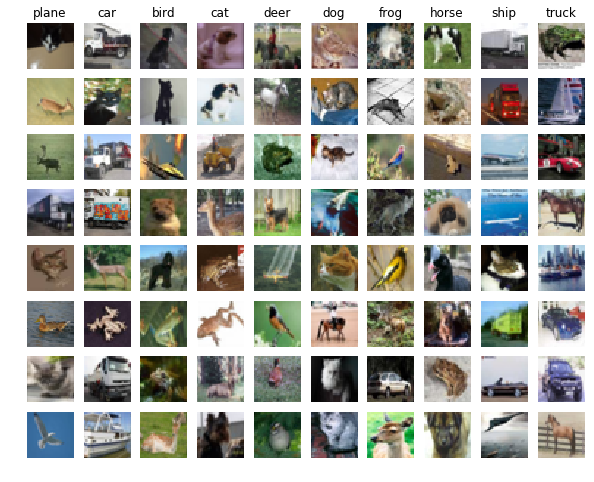

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


Answer:
Although there are a lot of results are misclassified, some of them make sense. This is because some of these image's texture are very close to the corrent one and some of the color of the image is very close to the corrent one. For example the deer one, the back ground color is mostly likely to be green, in the wood or on the grass. How  ever, the bird is classified in to this class, maybe because its green background. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print(X_train_feats.shape)
print(input_size)

(49000, 155)
3072


In [22]:
from cs231n.classifiers.neural_net import TwoLayerNet
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
hidden_size = [230]

results = {}
best_val_acc = 0
best_net = None

# learning_rates = np.array([0.7, 0.8, 0.9, 1, 1.1])*1e-3
# regularization_strengths = [0.75, 1, 1.25]
regularization_strengths = [0]
learning_rates = [1.600000e-01]

for hs in hidden_size:
    for lr in learning_rates:
        for reg in regularization_strengths:
            print((hs,lr,reg))
           
        
            input_size = 32 * 32 * 3
            hidden_size = hs
            num_classes = 10
            net = TwoLayerNet(X_train_feats.shape[1], hidden_size, num_classes)

            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=10000, batch_size=30,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=True)
        
        
            
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net         
            results[(hs,lr,reg)] = val_acc

# Print out results.
for hs,lr, reg in sorted(results):
    val_acc = results[(hs, lr, reg)]
    print( 'hs %d lr %e reg %e val accuracy: %f' % (hs, lr, reg,  val_acc))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(230, 0.16, 0)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.290256
iteration 200 / 10000: loss 1.880512
iteration 300 / 10000: loss 1.397390
iteration 400 / 10000: loss 1.517079
iteration 500 / 10000: loss 1.561510
iteration 600 / 10000: loss 1.533156
iteration 700 / 10000: loss 1.184213
iteration 800 / 10000: loss 1.561271
iteration 900 / 10000: loss 1.410055
iteration 1000 / 10000: loss 1.155657
iteration 1100 / 10000: loss 1.173196
iteration 1200 / 10000: loss 1.324299
iteration 1300 / 10000: loss 1.631372
iteration 1400 / 10000: loss 1.348004
iteration 1500 / 10000: loss 1.580441
iteration 1600 / 10000: loss 1.241589
iteration 1700 / 10000: loss 1.323290
iteration 1800 / 10000: loss 1.571688
iteration 1900 / 10000: loss 1.192713
iteration 2000 / 10000: loss 1.269400
iteration 2100 / 10000: loss 1.382051
iteration 2200 / 10000: loss 1.253856
iteration 2300 / 10000: loss 1.005372
iteration 2400 / 10000: loss 1.291938
iteration 2500 / 10000: loss 1.019314
iteration

In [23]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)
#hs 230 lr 1.600000e-01 reg 0.000000e+00 val accuracy: 0.557000

0.564


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!